In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
import pandas as pd
import os.path
from pathlib import Path
import pickle
import multiprocessing
import time
import gc
from numba import jit
import IPython.display as ipd
from scipy.interpolate import interp1d

In [3]:
%matplotlib inline
%load_ext Cython

# FlexDTW Implementation

From https://github.com/HMC-MIR/FlexDTW

In [4]:
@jit(nopython=True)
def flexdtw_alt(C, steps, weights, buffer=1):
    '''
    Implementation of DTW Star version 0.2a.  
    
    Inputs
    C: pairwise cost matrix
    steps: a numpy matrix specifying the allowable transitions.  It should be of
        dimension (L, 2), where each row specifies (row step, col step)
    weights: a array that specifies the multiplicative weights for each transition
        type.  The length of this array must match the number of possible transitions.
    buffer: specifies 
    
    Outputs
    best_cost: the best average cost per manhattan block
    path: the estimated warping path, specified as a 2xN array
    debug: Debugging information for examining the average cost per manhattan block for each 
        of the candidate ending positions.
    '''
    
    # initialize
    D = np.zeros(C.shape)
    B = np.zeros(C.shape, dtype=np.int8)
    P = np.zeros(C.shape, dtype=np.int32)
    D[0,:] = C[0,:]
    D[:,0] = C[:,0]
    
    # DP
    for row in range(1,C.shape[0]):
        for col in range(1, C.shape[1]):
            
            mincost = np.inf
            minidx = -1
            bestrprev = -1
            bestcprev = -1
            
            # find best transition
            for stepidx, step in enumerate(steps):
                
                (rstep, cstep) = step
                prevrow = row - rstep
                prevcol = col - cstep
                
                if prevrow >= 0 and prevcol >= 0:
                    
                    pathcost = D[prevrow, prevcol] + C[row, col] * weights[stepidx]
                    
                    if pathcost < mincost:
                        
                        mincost = pathcost
                        minidx = stepidx
                        bestrprev = prevrow
                        bestcprev = prevcol
            
            # update D, B, P
            D[row, col] = mincost
            B[row, col] = minidx
            if bestrprev == 0:
                P[row, col] = bestcprev
            elif bestcprev == 0:
                P[row, col] = -1*bestrprev
            else:
                P[row, col] = P[bestrprev, bestcprev]
            
    #  backtrack
    best_cost, best_r, best_c, debug = find_best_endpoint(D, P, buffer)
    path = backtrace_flexdtw(D, B, steps, best_r, best_c)
    path.reverse()
    path = np.array(path).T 
    
    return best_cost, path, debug, D, B, P

In [5]:
@jit(nopython=True)
def find_best_endpoint(D, P, buffer):
    '''
    Determines the best location to begin backtracking from by comparing the average path cost
    per manhattan block.
    
    Inputs
    D: the cumulative cost matrix
    P: the matrix specifying the starting location of the alignment path
    buffer: specifies the length of a buffer region (in frames) to avoid short degenerate alignment paths
        near the corners of the pairwise cost matrix.  This can be thought of as the minimum length that
        needs to match in order to be considered a valid alignment path.
    
    Outputs
    best_cost: the best average path cost per manhattan block
    best_r: the row index of the best endpoint
    best_c: the column index of the best endpoint
    debug: debugging information for examining the average cost per manhattan block for each 
        of the candidate ending positions
    '''
    
    # consider last row and column as candidates
    candidates = [(D.shape[0]-1,i) for i in range(buffer, D.shape[1])] + [(i, D.shape[1]-1) for i in range(buffer, D.shape[0]-1)][::-1]
    
    best_cost = np.inf
    best_r, best_c = -1, -1
    debug = []
    
    for i, (r,c) in enumerate(candidates):
                
        # get alignment start location
        if P[r,c] >= 0:
            rstart, cstart = 0, P[r,c]
        else:
            rstart, cstart = -P[r,c], 0
            
        # calculate average cost per manhattan block
        mdist = (r - rstart) + (c - cstart) # manhattan distance
        avg_cost_per_mb = D[r,c] / mdist
        
        # keep best
        if avg_cost_per_mb < best_cost:
            best_cost = avg_cost_per_mb
            best_r, best_c = r, c
            
        # debugging info
        if r == D.shape[0]-1:
            debug.append((c-D.shape[1]+1, avg_cost_per_mb, r, c))
        else:
            debug.append((D.shape[0]-1-r, avg_cost_per_mb, r, c))
    
    return best_cost, best_r, best_c, debug

In [6]:
@jit(nopython=True)
def backtrace_flexdtw(D, B, steps, rstart, cstart):
    '''
    Backtraces through the cumulative cost matrix D starting from a specified location.
    
    Arguments:
    D: cumulative cost matrix
    B: backtrace matrix
    steps: a numpy matrix specifying the allowable transitions.  It should be of
            dimension (L, 2), where each row specifies (row step, col step)
    rstart: the row index to start backtracking from
    cstart: the column index to start backtracking from
    
    Outputs
    path: a python list of (row, col) coordinates for the optimal path.
    '''
    pos = (rstart, cstart)
    path = []
    path.append(pos)
    while(pos[0] != 0 and pos[1] != 0):
        (row, col) = pos
        stepidx = B[row, col]
        (rstep, cstep) = steps[stepidx]
        pos = (row-rstep, col-cstep)
        path.append(pos)
    
    return path

In [7]:
def online_flex_dtw(C, steps, weights, buffer_fraction=0.5, L=1000):
    """
    Computes the optimal path through a cost matrix using an online method, taking windows of length L 
    and applying FlexDTW to each one.

    Inputs
    C: pairwise cost matrix
    steps: a numpy matrix specifying the allowable transitions.  It should be of
        dimension (L, 2), where each row specifies (row step, col step)
    weights: a array that specifies the multiplicative weights for each transition
        type.  The length of this array must match the number of possible transitions.
    buffer_fraction: specifies the length of a buffer region (in frames) to avoid short degenerate alignment paths
        near the corners of the pairwise cost matrix.  This can be thought of as the minimum length that
        needs to match in order to be considered a valid alignment path. The buffer length is the buffer_fraction times L.
    L: square window size to find path through

    
    Outputs
    best_cost: the best average cost per manhattan block
    full_path: the estimated warping path, specified as a 2xN array
    """

    if buffer_fraction > 1 or buffer_fraction < 0:
        raise ValueError("buffer_fraction argument must be between 0 and 1")
    buffer = int(L*buffer_fraction)
        

    # start at bottom left of 
    row = 0
    col = 0

    num_rows, num_cols = C.shape

    full_path = []

    # iterate while we can do full windows
    while(row < (num_rows - L) and col < (num_cols - L)):
        C_window = C[row:row+L, col:col+L]
        _, path, _, _, _, _ = flexdtw_alt(C_window, steps, weights, buffer=buffer)

        end_row, end_col = path[:, -1]

        # make path into global indexing instead of relative
        global_offset = np.zeros(path.shape, dtype=np.int64)
        global_offset[0, :] = row
        global_offset[1, :] = col
        path += global_offset

        row = row + end_row
        col = col + end_col
        
        full_path.append(path)

    # do last window, won't be full size
    start_row = row
    end_row = min(row + L, num_rows)

    start_col = col
    end_col = min(col + L, num_cols)

    C_window = C[start_row:end_row, start_col:end_col]
    buffer_size = min((end_row - start_row)/2, (end_col - start_col)/2)
    _, path, _, _, _, _ = flexdtw_alt(C_window, steps, weights, buffer=buffer_size)

    end_row, end_col = path[:, -1]

    # make path into global indexing instead of relative
    global_offset = np.zeros(path.shape, dtype=np.int64)
    global_offset[0, :] = row
    global_offset[1, :] = col
    path += global_offset
    
    row = row + end_row
    col = col + end_col

    full_path.append(path)

    
    # concatenate arrays along coordinate axis
    full_path = np.concatenate(full_path, axis=1)

    return full_path


In [8]:
def mapFrame(r, c, Dshape, frames=False):
    if frames: #  frames, use exact
        if r == Dshape[0]-1:
            val = c-D.shape[1]+1
        else:
            val = D.shape[0]-1-r
    else: # seconds, use approximate
        distr = np.abs(r-Dshape[0])
        distc = np.abs(c-Dshape[1])
        if distr < distc:
            val = c-Dshape[1]
        else:
            val = Dshape[0]-r
    return val

In [9]:
def L2norm(F):
    L2norm = np.sqrt(np.sum(F*F, axis = 0)) + 1e-9
    Fnorm = F / L2norm.reshape((1,-1))
    return Fnorm

In [10]:
def compute_cosdist_cost(F_query, F_ref):
    """
    Computes the cosine distance cost matrix for a reference feature matrix and a query feature matrix.
    """

    return 1 - L2norm(F_query).T @ L2norm(F_ref)

In [11]:
def getTimestamps(annotfile1, annotfile2):
    df1 = pd.read_csv(annotfile1, header=None, sep='\s+', skiprows=3) 
    df2 = pd.read_csv(annotfile2, header=None, sep='\s+', skiprows=3)
    
    # df_merged = df1.merge(df2, on=[2], how='left')
    # df_merged.to_csv("merged_test.csv")

    return np.array(df1[0]), np.array(df2[0])

In [12]:
ashkenazy_audio, sr_a = lb.load("/home/dherrera/ttmp/alignment_data/Chopin_Op017No4_Ashkenazy-1981_pid9058-13.wav")
block_audio, sr_b = lb.load("/home/dherrera/ttmp/alignment_data/Chopin_Op017No4_Block-1995_pid9064-04.wav")

In [13]:
# Compute chroma features
F_a = lb.feature.chroma_stft(y=ashkenazy_audio, sr=sr_a)
F_b = lb.feature.chroma_stft(y=block_audio, sr=sr_b)


In [14]:
# Compute pairwise cost comparison matrix
C = compute_cosdist_cost(F_a, F_b)
print(C.shape)

(11024, 13908)


In [15]:
steps = np.array([1, 1, 1, 2, 2, 1]).reshape((-1,2))
weights = np.array([2,3,3])
hop_sec = 512/22050
buffer = 10 # in sec

In [16]:
annotfile_a = "/home/dherrera/ttmp/alignment_data/Chopin_Op017No4_Ashkenazy-1981_pid9058-13.beat"
annotfile_b = "/home/dherrera/ttmp/alignment_data/Chopin_Op017No4_Block-1995_pid9064-04.beat"
gt1, gt2 = getTimestamps(annotfile_a, annotfile_b)
gt_path = np.array([gt1, gt2])


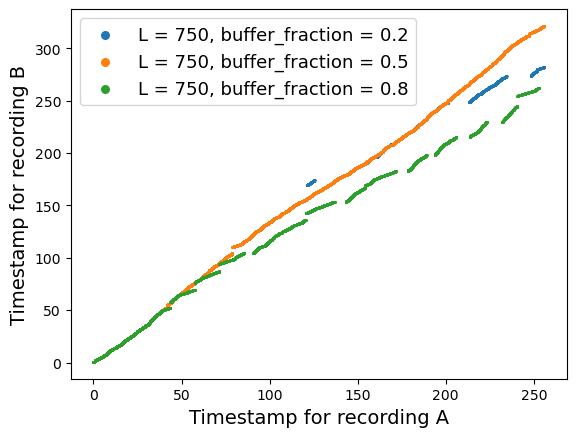

In [41]:
for buf_frac in [0.2, 0.5, 0.8]:
    wp_ol = online_flex_dtw(C, steps, weights, L=750, buffer_fraction=buf_frac) * 512/22050
    plt.scatter(wp_ol[0,:], wp_ol[1,:], label=f"L = 750, buffer_fraction = {buf_frac}", s=1)

lgnd = plt.legend(fontsize=13)
for handle in lgnd.legend_handles:
    handle._sizes = [30]
plt.xlabel("Timestamp for recording A", fontsize=14)
plt.ylabel("Timestamp for recording B", fontsize=14)
plt.savefig("buf_test.png", dpi=300)
plt.show()


In [21]:
start = time.time()
best_cost, wp, debug, _, _, _ = flexdtw_alt(C, steps, weights, buffer/hop_sec)
print("% s seconds" % (time.time() - start))
X = np.array(debug)
times = X[:,0]*hop_sec
scores = X[:,1]
# plt.plot(times, scores,'.')
# plt.axvline(times.min()+10, color='r')
# plt.axvline(times.max()-10, color='r')
# plt.axvline(mapFrame(gt1[-1], gt2[-1], (F_a.shape[1]*hop_sec, F_b.shape[1]*hop_sec)), color='g')

3.8637685775756836 seconds


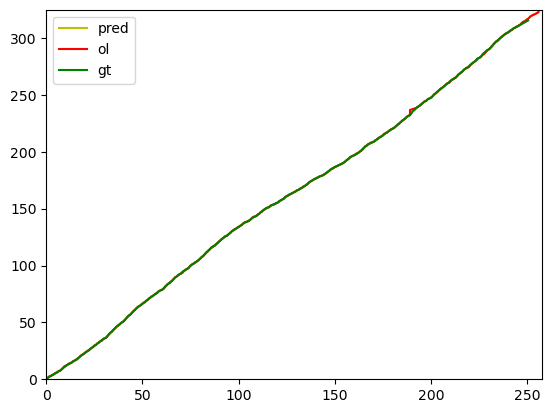

In [22]:
plt.plot(wp[0,:]*hop_sec, wp[1,:]*hop_sec, 'y-')
plt.plot(wp_ol[0,:]*hop_sec, wp_ol[1,:]*hop_sec, 'r-')
plt.plot(gt1, gt2, 'g')
plt.legend(['pred', 'ol', 'gt',])
plt.xlim([0, F_a.shape[1]*hop_sec+2])
plt.ylim([0, F_b.shape[1]*hop_sec+2])
plt.show()

In [23]:
def get_error(ground_truth, est_path):
    gt_x = ground_truth[0, :]
    gt_y = ground_truth[1, :]

    est_x = est_path[0, :]
    est_y = est_path[1, :]

    interpolate = interp1d(est_x, est_y)
    est_along_gt = interpolate(gt_x)

    error = est_along_gt - gt_y

    return error

In [66]:
test_Ls = [10, 50, 500, 1000, 5000, 10000]
errors = []
paths = []
times = []
for test_L in test_Ls:
    start_t = time.time()
    online_path = online_flex_dtw(C, steps, weights, L=test_L)
    delta_t = time.time() - start_t
    error = get_error(gt_path, online_path*hop_sec)

    errors.append(error)
    paths.append(online_path*hop_sec)
    times.append(delta_t)



In [67]:
times

[0.030689001083374023,
 0.030883073806762695,
 0.1865687370300293,
 0.35991525650024414,
 2.076706886291504,
 3.455906391143799]

In [28]:
match_alignment = np.load("Match_Alignment.npy")
match_alignment2 = np.load("/home/dherrera/ttmp/Online-DTW/experiments_train/MATCH_clean/Chopin_Op017No4_Ashkenazy-1981_pid9058-13__Chopin_Op017No4_Block-1995_pid9064-04.pkl", allow_pickle=True)

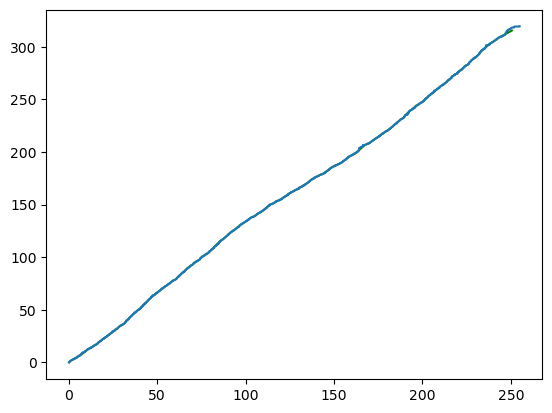

In [30]:
plt.plot(gt1, gt2, 'g')
plt.plot(match_alignment2[1], match_alignment2[0])
plt.show()

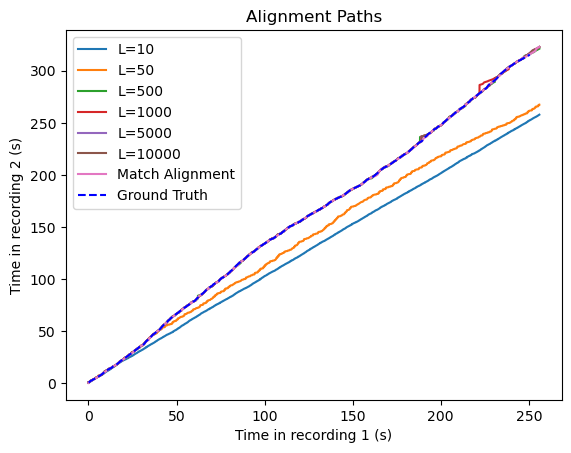

In [71]:
for idx, path in enumerate(paths):
    plt.plot(path[0, :], path[1, :], label=f'L={test_Ls[idx]}')

plt.plot(match_alignment[0, :], match_alignment[1, :], label='Match Alignment')
plt.plot(gt1, gt2, 'b--', label='Ground Truth')

plt.xlabel("Time in recording 1 (s)")
plt.ylabel("Time in recording 2 (s)")
plt.title("Alignment Paths")
plt.legend()
plt.show()


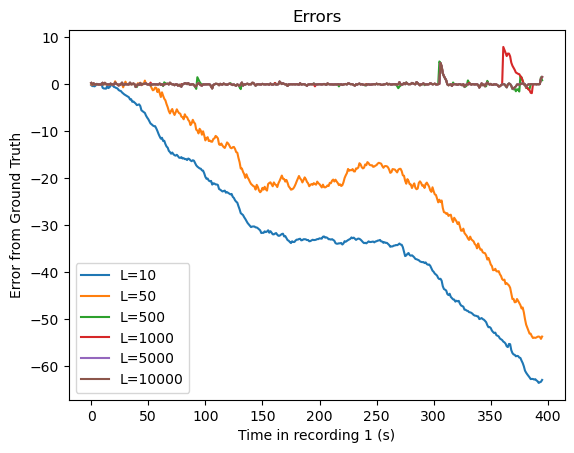

In [62]:
for idx, err in enumerate(errors):
    plt.plot(err, label=f'L={test_Ls[idx]}')
plt.xlabel("Time in recording 1 (s)")
plt.ylabel("Error from Ground Truth")
plt.title("Errors")
plt.legend()
plt.show()
